In [1]:
import numpy as np 
import os
import cv2

import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
from keras.metrics import accuracy
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [4]:
def fcn_2s(input_size = (256,256,3)):
    
    inputs = Input(input_size)
    x = BatchNormalization()(inputs)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    block_1 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    block_2 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    block_3 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    block_4 = Conv2D(3, (1, 1), activation='relu', padding='same')(x)
    
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)

    block_5 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(x)
    
    sum_1 = add([block_4, block_5])
    sum_1 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(sum_1)
    
    sum_2 = add([block_3, sum_1])
    sum_2 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(sum_2)
    
    sum_3 = add([block_2, sum_2])
    sum_3 = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='same')(sum_3) 
    
    sum_4 = add([block_1, sum_3])   
    x = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), activation='sigmoid', padding='same')(sum_4)
    
    model = Model(inputs = inputs, outputs = x)

    model.compile(optimizer = Adam(learning_rate = 2e-4), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])
    
    return model

In [5]:
def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    
    drop4 = Dropout(0.5)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(3, 3, activation = 'sigmoid', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    # conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer = Adam(learning_rate = 0.002), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])

    
    return model

In [6]:
def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path
    
def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path


def res_unet1(input_shape = (256,256,3)):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=3, kernel_size=(1, 1), activation='sigmoid')(path)
    
    model = Model(inputs=inputs, outputs=path)
    model.compile(optimizer = Adam(learning_rate = 0.002), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])
    
    return model

In [7]:
def Unet_plus(input_size = (256, 256, 3)):
    inputs = Input(input_size)
  
    x = BatchNormalization()(inputs)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(x)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    
    drop4 = Dropout(0.1)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    
    drop5 = Dropout(0.1)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)


    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(3, 3, activation = 'sigmoid', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)


    # conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer = Adam(learning_rate = 0.002), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])

    
    return model

In [8]:
kernel = np.zeros((3, 3), np.float32)
kernel.itemset((3//2, 3//2), 2)
kernel -= np.ones((3, 3), np.float32)/(3**2)

In [9]:
model_Unet_Mass = unet()
model_FCN_Mass = fcn_2s()
model_resUnet_Mass = res_unet1()
model_Unetplus_Mass = Unet_plus()
model_Unet_Deep = unet()
model_FCN_Deep = fcn_2s()
model_resUnet_Deep = res_unet1()
model_Unetplus_Deep = Unet_plus()

In [10]:
print('*'*30)
print('Loading saved weights...')
print('*'*30)
model_Unet_Mass.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/UnetwithMass_200epochs.h5')
model_FCN_Mass.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/FCNwithMass_200epochs.h5')
model_resUnet_Mass.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/resUnetwithMass_200epochs.h5')
model_Unetplus_Mass.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/UnetpluswithMass_200epochs.h5')

model_Unet_Deep.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/UnetwithDeep_200epochs.h5')
model_FCN_Deep.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/FCNwithDeep_200epochs.h5')
model_resUnet_Deep.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/resUnetwithDeep_200epochs.h5')
model_Unetplus_Deep.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/UnetpluswithDeep_200epochs.h5')

******************************
Loading saved weights...
******************************


### Test model with Deep_Globe Dataset

In [11]:
def listOfFilesDeep(directory, condition):

    x = []

    for root, dirs, files in os.walk(directory):

        for name in files:

            if condition in name:

              filename = os.path.join(root, name)

              y = filename.split('\\')

              x.append(y[0])
            
    x.sort()

    return x

In [16]:
path_pred = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/DeepGlobe_Road_Extraction_Dataset/test'
condition_pred = '_sat.jpg'
img_pred_path = listOfFilesDeep(path_pred, condition_pred)
condition_mask = '_mask.png'
img_mask_path = listOfFilesDeep(path_pred, condition_mask)

img_pred_deep = []
img_mask_deep = []

for i in range(10):
  pred_im = cv2.resize(cv2.cvtColor(cv2.imread(img_pred_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  mask_im = cv2.resize(cv2.cvtColor(cv2.imread(img_mask_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  pred_im = cv2.filter2D(pred_im, -1, kernel)
  img_pred_deep.append(pred_im)
  img_mask_deep.append(mask_im)

img_pred_deep = np.array(img_pred_deep)
img_pred_deep = img_pred_deep.astype('float32')
img_pred_deep /= 255

img_mask_deep = np.array(img_mask_deep)
img_mask_deep = img_mask_deep.astype('float32')
img_mask_deep /= 255

In [17]:
print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred_deep1 = model_Unet_Deep.predict(img_pred_deep, verbose=1)
mask_pred_deep2 = model_FCN_Deep.predict(img_pred_deep, verbose=1)
mask_pred_deep3 = model_resUnet_Deep.predict(img_pred_deep, verbose=1)
mask_pred_deep4 = model_Unetplus_Deep.predict(img_pred_deep, verbose=1)

******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 19s 19s/step


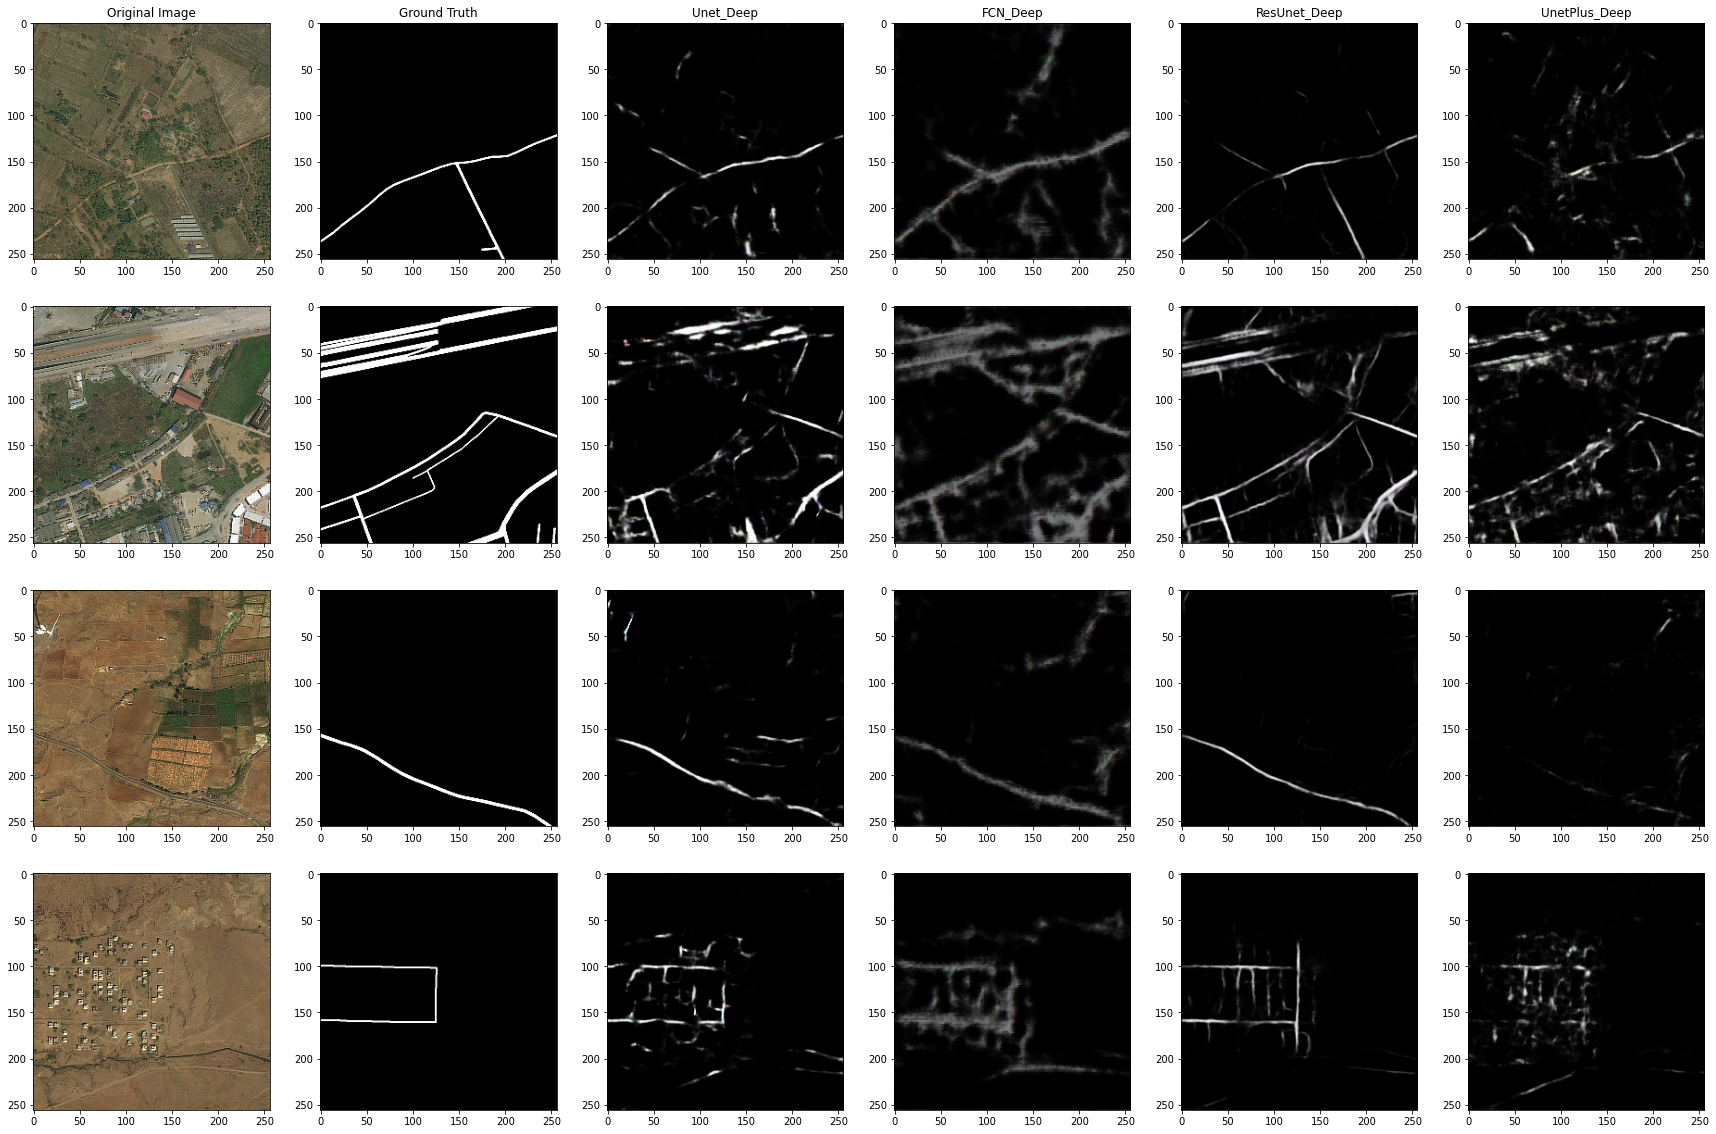

In [18]:
fig, ax = plt.subplots(4, 6, figsize=(30, 20))

ax[0,0].set_title('Original Image')
ax[0,0].imshow(img_pred_deep[0])
ax[1,0].imshow(img_pred_deep[1])
ax[2,0].imshow(img_pred_deep[2])
ax[3,0].imshow(img_pred_deep[4])

ax[0,1].set_title('Ground Truth')
ax[0,1].imshow(img_mask_deep[0])
ax[1,1].imshow(img_mask_deep[1])
ax[2,1].imshow(img_mask_deep[2])
ax[3,1].imshow(img_mask_deep[4])

ax[0,2].set_title('Unet_Deep')
ax[0,2].imshow(mask_pred_deep1[0])
ax[1,2].imshow(mask_pred_deep1[1])
ax[2,2].imshow(mask_pred_deep1[2])
ax[3,2].imshow(mask_pred_deep1[4])

ax[0,3].set_title('FCN_Deep')
ax[0,3].imshow(mask_pred_deep2[0])
ax[1,3].imshow(mask_pred_deep2[1])
ax[2,3].imshow(mask_pred_deep2[2])
ax[3,3].imshow(mask_pred_deep2[4])

ax[0,4].set_title('ResUnet_Deep')
ax[0,4].imshow(mask_pred_deep3[0])
ax[1,4].imshow(mask_pred_deep3[1])
ax[2,4].imshow(mask_pred_deep3[2])
ax[3,4].imshow(mask_pred_deep3[4])

ax[0,5].set_title('UnetPlus_Deep')
ax[0,5].imshow(mask_pred_deep4[0])
ax[1,5].imshow(mask_pred_deep4[1])
ax[2,5].imshow(mask_pred_deep4[2])
ax[3,5].imshow(mask_pred_deep4[4])

### Test model with Massachuset Dataset

In [19]:
def listOfFilesMass(directory):

    x = []

    for root, dirs, files in os.walk(directory):

        for name in files:

            filename = os.path.join(root, name)

            y = filename.split('\\')

            x.append(y[0])
            
    x.sort()

    return x

In [25]:
path_pred_mass = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/Massachusetts_Roads_Dataset/tiff/val'
path_mask_mass = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/Massachusetts_Roads_Dataset/tiff/val_labels'
img_pred_path_mass = listOfFilesMass(path_pred_mass)
img_mask_path_mass = listOfFilesMass(path_mask_mass)
img_pred_mass = []
img_mask_mass = []

for i in range(len(img_pred_path_mass)):
  pred_im = cv2.resize(cv2.cvtColor(cv2.imread(img_pred_path_mass[i]),cv2.COLOR_BGR2RGB), (256, 256))
  mask_im = cv2.resize(cv2.cvtColor(cv2.imread(img_mask_path_mass[i]),cv2.COLOR_BGR2RGB), (256, 256))
  pred_im = cv2.filter2D(pred_im, -1, kernel)
  img_pred_mass.append(pred_im)
  img_mask_mass.append(mask_im)

img_pred_mass = np.array(img_pred_mass)
img_pred_mass = img_pred_mass.astype('float32')
img_pred_mass /= 255

img_mask_mass = np.array(img_mask_mass)
img_mask_mass = img_mask_mass.astype('float32')
img_mask_mass /= 255

In [26]:
print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred_mass1 = model_Unet_Mass.predict(img_pred_mass, verbose=1)
mask_pred_mass2 = model_FCN_Mass.predict(img_pred_mass, verbose=1)
mask_pred_mass3 = model_resUnet_Mass.predict(img_pred_mass, verbose=1)
mask_pred_mass4 = model_Unetplus_Mass.predict(img_pred_mass, verbose=1)

******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 28s 28s/step


In [27]:
fig, ax = plt.subplots(4, 6, figsize=(30, 20))

ax[0,0].set_title('Original Image')
ax[0,0].imshow(img_pred_mass[0])
ax[1,0].imshow(img_pred_mass[1])
ax[2,0].imshow(img_pred_mass[2])
ax[3,0].imshow(img_pred_mass[3])

ax[0,1].set_title('Ground Truth')
ax[0,1].imshow(img_mask_mass[0])
ax[1,1].imshow(img_mask_mass[1])
ax[2,1].imshow(img_mask_mass[2])
ax[3,1].imshow(img_mask_mass[3])

ax[0,2].set_title('Unet_Mass')
ax[0,2].imshow(mask_pred_mass1[0])
ax[1,2].imshow(mask_pred_mass1[1])
ax[2,2].imshow(mask_pred_mass1[2])
ax[3,2].imshow(mask_pred_mass1[3])

ax[0,3].set_title('FCN_Mass')
ax[0,3].imshow(mask_pred_mass2[0])
ax[1,3].imshow(mask_pred_mass2[1])
ax[2,3].imshow(mask_pred_mass2[2])
ax[3,3].imshow(mask_pred_mass2[3])

ax[0,4].set_title('ResUnet_Mass')
ax[0,4].imshow(mask_pred_mass3[0])
ax[1,4].imshow(mask_pred_mass3[1])
ax[2,4].imshow(mask_pred_mass3[2])
ax[3,4].imshow(mask_pred_mass3[3])

ax[0,5].set_title('UnetPlus_Mass')
ax[0,5].imshow(mask_pred_mass4[0])
ax[1,5].imshow(mask_pred_mass4[1])
ax[2,5].imshow(mask_pred_mass4[2])
ax[3,5].imshow(mask_pred_mass4[3])

Output hidden; open in https://colab.research.google.com to view.

### Test on Map from Open Street Map

In [28]:
path_pred_demo = '/content/drive/MyDrive/NIDA/Image_analytics/Project/demo_dataset/'
img_pred_path_demo = listOfFilesMass(path_pred_demo)
img_pred_demo = []

for i in range(len(img_pred_path_demo)):
  pred_im = cv2.resize(cv2.cvtColor(cv2.imread(img_pred_path_demo[i]),cv2.COLOR_BGR2RGB), (256, 256))
  pred_im = cv2.filter2D(pred_im, -1, kernel)
  img_pred_demo.append(pred_im)

img_pred_demo = np.array(img_pred_demo)
img_pred_demo = img_pred_demo.astype('float32')
img_pred_demo /= 255

In [29]:
print('*'*30)
print('Predicting masks on test data...')
print('*'*30)

mask_pred_deep1_demo = model_Unet_Deep.predict(img_pred_demo, verbose=1)
mask_pred_deep2_demo = model_FCN_Deep.predict(img_pred_demo, verbose=1)
mask_pred_deep3_demo = model_resUnet_Deep.predict(img_pred_demo, verbose=1)
mask_pred_deep4_demo = model_Unetplus_Deep.predict(img_pred_demo, verbose=1)

mask_pred_mass1_demo = model_Unet_Mass.predict(img_pred_demo, verbose=1)
mask_pred_mass2_demo = model_FCN_Mass.predict(img_pred_demo, verbose=1)
mask_pred_mass3_demo = model_resUnet_Mass.predict(img_pred_demo, verbose=1)
mask_pred_mass4_demo = model_Unetplus_Mass.predict(img_pred_demo, verbose=1)

******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 10s 10s/step


In [30]:
fig, ax = plt.subplots(5, 9, figsize=(30, 20))

ax[0,0].set_title('Original Image')
ax[0,0].imshow(img_pred_demo[0])
ax[1,0].imshow(img_pred_demo[1])
ax[2,0].imshow(img_pred_demo[2])
ax[3,0].imshow(img_pred_demo[3])
ax[4,0].imshow(img_pred_demo[4])

ax[0,1].set_title('Unet_Mass')
ax[0,1].imshow(mask_pred_mass1_demo[0])
ax[1,1].imshow(mask_pred_mass1_demo[1])
ax[2,1].imshow(mask_pred_mass1_demo[2])
ax[3,1].imshow(mask_pred_mass1_demo[3])
ax[4,1].imshow(mask_pred_mass1_demo[4])

ax[0,2].set_title('FCN_Mass')
ax[0,2].imshow(mask_pred_mass2_demo[0])
ax[1,2].imshow(mask_pred_mass2_demo[1])
ax[2,2].imshow(mask_pred_mass2_demo[2])
ax[3,2].imshow(mask_pred_mass2_demo[3])
ax[4,2].imshow(mask_pred_mass2_demo[4])

ax[0,3].set_title('ResUnet_Mass')
ax[0,3].imshow(mask_pred_mass3_demo[0])
ax[1,3].imshow(mask_pred_mass3_demo[1])
ax[2,3].imshow(mask_pred_mass3_demo[2])
ax[3,3].imshow(mask_pred_mass3_demo[3])
ax[4,3].imshow(mask_pred_mass3_demo[4])

ax[0,4].set_title('UnetPlus_Mass')
ax[0,4].imshow(mask_pred_mass4_demo[0])
ax[1,4].imshow(mask_pred_mass4_demo[1])
ax[2,4].imshow(mask_pred_mass4_demo[2])
ax[3,4].imshow(mask_pred_mass4_demo[3])
ax[4,4].imshow(mask_pred_mass4_demo[4])

ax[0,5].set_title('Unet_Deep')
ax[0,5].imshow(mask_pred_deep1_demo[0])
ax[1,5].imshow(mask_pred_deep1_demo[1])
ax[2,5].imshow(mask_pred_deep1_demo[2])
ax[3,5].imshow(mask_pred_deep1_demo[3])
ax[4,5].imshow(mask_pred_deep1_demo[4])

ax[0,6].set_title('FCN_Deep')
ax[0,6].imshow(mask_pred_deep2_demo[0])
ax[1,6].imshow(mask_pred_deep2_demo[1])
ax[2,6].imshow(mask_pred_deep2_demo[2])
ax[3,6].imshow(mask_pred_deep2_demo[3])
ax[4,6].imshow(mask_pred_deep2_demo[4])

ax[0,7].set_title('ResUnet_Deep')
ax[0,7].imshow(mask_pred_deep3_demo[0])
ax[1,7].imshow(mask_pred_deep3_demo[1])
ax[2,7].imshow(mask_pred_deep3_demo[2])
ax[3,7].imshow(mask_pred_deep3_demo[3])
ax[4,7].imshow(mask_pred_deep3_demo[4])

ax[0,8].set_title('UnetPlus_Deep')
ax[0,8].imshow(mask_pred_deep4_demo[0])
ax[1,8].imshow(mask_pred_deep4_demo[1])
ax[2,8].imshow(mask_pred_deep4_demo[2])
ax[3,8].imshow(mask_pred_deep4_demo[3])
ax[4,8].imshow(mask_pred_deep4_demo[4])

Output hidden; open in https://colab.research.google.com to view.